In [ ]:
# ========================
#  INSTALL DEPENDENCIES
# ========================
import sys

# Install required packages
%pip install --quiet torch torchvision tqdm pandas numpy pillow statsmodels matplotlib

# Restart runtime required after installing packages
print("\n⚠️ NOTE: You need to restart the runtime after installing packages!")
print("1. Runtime -> Restart runtime")
print("2. Then run all cells from the beginning\n")

# Verify installations
import torch
import torchvision
print("\n✅ PyTorch Version:", torch.__version__)
print("✅ Torchvision Version:", torchvision.__version__)
print("✅ CUDA Available:", torch.cuda.is_available())

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("🔥 Using Device:", device)

# Optional: For better notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os

# Custom Dataset for Solar Panel Images
class SolarPanelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        img = img.resize((224, 224))
        img = np.array(img) / 255.0
        img = torch.FloatTensor(img).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            img = self.transform(img)
            
        # Target is relative power (p_rel)
        target = torch.FloatTensor([self.df.iloc[idx]["p_rel"]])
        return img, target

# Physics-based Model (Linear Regression)
class PhysicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = 0.2  # Inactive pixel threshold
        
    def forward(self, x):
        # x is expected to be [B, 1, 224, 224]
        x = x.squeeze(1)  # Remove channel dim for calculations
        
        # Calculate inactive percentage
        inactive_mask = (x < self.threshold).float()
        inactive_pct = inactive_mask.mean(dim=(1, 2))
        
        # Apply linear regression (using coefficients from your existing model)
        pred = 1.5752 * inactive_pct - 0.6471  # Using your model's coefficients
        
        return pred.unsqueeze(1), inactive_pct.unsqueeze(1)

# Modified ResNet18
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained ResNet18
        resnet = models.resnet18(pretrained=True)
        
        # Modify first layer for grayscale
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        weight = resnet.conv1.weight.sum(dim=1, keepdim=True)
        self.conv1.weight.data = weight
        
        # Rest of ResNet
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        x = self.fc(features)
        return x, features

# Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.physics_model = PhysicsModel()
        self.resnet_model = ModifiedResNet18()
        self.meta = nn.Linear(2, 1)
        
    def forward(self, x):
        # Get predictions from both models
        pred_physics, _ = self.physics_model(x)
        pred_resnet, _ = self.resnet_model(x)
        
        # Combine predictions
        combined = torch.cat([pred_physics, pred_resnet], dim=1)
        final_pred = self.meta(combined)
        
        return final_pred

# Training utilities
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_ensemble_model.pth')
            
def predict_power(model, image_path, device='cuda'):
    # Load and preprocess image
    img = Image.open(image_path).convert('L')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    img = img.to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        pred = model(img)
    
    return pred.item()


# Load Up and Sanity Check

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import zipfile

# ========================
#  STEP 1: DEFINE PATHS
# ========================
csv_path = "/content/data.csv"
zip_path = "/content/processed.zip"
image_dir = "/content/processed/processed/processed"

# ========================
#  STEP 2: UNZIP IMAGES IF NOT YET EXTRACTED
# ========================
if not os.path.exists(image_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(image_dir)
    print("Images extracted to /content/processed/")
else:
    print("Images already extracted.")

# ========================
#  STEP 3: LOAD CSV + EXTRACT FEATURES
# ========================
df = pd.read_csv(csv_path)
df["image_path"] = df["Unnamed: 0"].apply(lambda x: os.path.join(image_dir, f"image_{x}.png"))

def extract_features(image_path):
    try:
        img = Image.open(image_path).convert("L").resize((224, 224))
        arr = np.array(img).flatten() / 255.0
        inactive_mask = arr < 0.2
        return {
            "mean": np.mean(arr),
            "std": np.std(arr),
            "skewness": skew(arr),
            "kurtosis": kurtosis(arr),
            "inactive_pct": np.sum(inactive_mask) / arr.size
        }
    except:
        return {k: np.nan for k in ["mean", "std", "skewness", "kurtosis", "inactive_pct"]}

features = [extract_features(p) for p in tqdm(df["image_path"], desc="📈 Extracting features")]
features_df = pd.DataFrame(features)
df = pd.concat([df, features_df], axis=1)

# ========================
#  STEP 4: SAVE & PREVIEW
# ========================
df.to_csv("/content/el_features.csv", index=False)
print(" Features extracted and saved to el_features.csv")
df.head()


Images already extracted.


📈 Extracting features: 100%|██████████| 719/719 [00:30<00:00, 23.80it/s]


 Features extracted and saved to el_features.csv


,Unnamed: 0,peak_power,nominal_power,pressure,excitation_class,module_type,module_instance,power_group,fold_0_train,fold_1_train,fold_2_train,fold_3_train,fold_4_train,image_path,mean,std,skewness,kurtosis,inactive_pct
0,0,205.649713,230,0.00,high,T1,0,8,True,True,True,False,True,/content/processed/processed/processed/image_0...,0.132273,0.035014,-0.684414,0.825949,0.985730
1,1,210.332472,230,0.04,high,T1,0,9,True,True,True,False,True,/content/processed/processed/processed/image_1...,0.132267,0.035040,-0.671235,0.810102,0.985013
2,2,208.171168,230,0.04,high,T1,0,9,True,True,True,False,True,/content/processed/processed/processed/image_2...,0.132272,0.034985,-0.670546,0.810438,0.985352
3,3,210.406543,230,0.08,high,T1,0,9,True,True,True,False,True,/content/processed/processed/processed/image_3...,0.132268,0.035210,-0.644266,0.779149,0.984395
4,4,208.471054,230,0.08,high,T1,0,9,True,True,True,False,True,/content/processed/processed/processed/image_4...,0.132273,0.035037,-0.665827,0.806850,0.985132


In [ ]:
# ========================
#  STEP 5: LOAD FEATURES
# ========================
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the features
df = pd.read_csv("/content/el_features.csv")

# ========================
#  STEP 5.5: CLEAN BAD VALUES
# ========================
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["inactive_pct", "nominal_power", "peak_power"])

if df.empty:
    raise ValueError("No valid rows left after cleaning. Check your data for NaNs or Infs.")
else:
    print(f"Proceeding with {len(df)} samples after cleaning.")

# ========================
#  STEP 6: PREPARE DATA
# ========================
# Calculate relative power
df["p_rel"] = df["peak_power"] / df["nominal_power"]

# Create dataset and split into train/val
dataset = SolarPanelDataset(df)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ========================
#  STEP 7: TRAIN ENSEMBLE
# ========================
# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnsembleModel().to(device)
optimizer = Adam([
    {'params': model.resnet_model.parameters(), 'lr': 0.0001},  # Lower learning rate for ResNet
    {'params': model.meta.parameters(), 'lr': 0.001}            # Higher learning rate for meta-layer
])
criterion = torch.nn.MSELoss()

# Training loop
print("\n🚀 Starting Ensemble Training...")
num_epochs = 20
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images, targets = images.to(device), targets.to(device)
        
        # Get predictions
        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss and update weights
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Update progress
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    physics_preds = []
    resnet_preds = []
    ensemble_preds = []
    true_values = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            # Get individual predictions
            phys_pred, _ = model.physics_model(images)
            resnet_pred, _ = model.resnet_model(images)
            ensemble_pred = model(images)
            
            # Calculate validation loss
            val_loss += criterion(ensemble_pred, targets).item()
            
            # Store predictions for analysis
            physics_preds.extend(phys_pred.cpu().numpy())
            resnet_preds.extend(resnet_pred.cpu().numpy())
            ensemble_preds.extend(ensemble_pred.cpu().numpy())
            true_values.extend(targets.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print epoch results
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Save if best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_ensemble_model.pth')
        print('✅ Saved new best model!')

# ========================
#  STEP 8: VISUALIZATION
# ========================
plt.figure(figsize=(15, 5))

# Plot 1: Training Progress
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Model Comparisons
plt.subplot(1, 3, 2)
plt.scatter(true_values, physics_preds, alpha=0.3, label='Physics', color='blue')
plt.scatter(true_values, resnet_preds, alpha=0.3, label='ResNet', color='green')
plt.scatter(true_values, ensemble_preds, alpha=0.3, label='Ensemble', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Perfect prediction line
plt.title('Model Comparisons')
plt.xlabel('True Power')
plt.ylabel('Predicted Power')
plt.legend()
plt.grid(True)

# Plot 3: Error Distribution
plt.subplot(1, 3, 3)
plt.hist(np.abs(np.array(physics_preds) - np.array(true_values)), alpha=0.3, label='Physics', color='blue')
plt.hist(np.abs(np.array(resnet_preds) - np.array(true_values)), alpha=0.3, label='ResNet', color='green')
plt.hist(np.abs(np.array(ensemble_preds) - np.array(true_values)), alpha=0.3, label='Ensemble', color='red')
plt.title('Error Distribution')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ========================
#  STEP 9: FINAL METRICS
# ========================
def calculate_metrics(preds, targets):
    mae = np.mean(np.abs(preds - targets))
    rmse = np.sqrt(np.mean((preds - targets)**2))
    return mae, rmse

# Convert to numpy arrays
physics_preds = np.array(physics_preds)
resnet_preds = np.array(resnet_preds)
ensemble_preds = np.array(ensemble_preds)
true_values = np.array(true_values)

# Calculate metrics for each model
physics_mae, physics_rmse = calculate_metrics(physics_preds, true_values)
resnet_mae, resnet_rmse = calculate_metrics(resnet_preds, true_values)
ensemble_mae, ensemble_rmse = calculate_metrics(ensemble_preds, true_values)

print("\n📊 Final Model Performance:")
print("\nPhysics Model:")
print(f"   MAE: {physics_mae:.4f}")
print(f"   RMSE: {physics_rmse:.4f}")
print("\nResNet Model:")
print(f"   MAE: {resnet_mae:.4f}")
print(f"   RMSE: {resnet_rmse:.4f}")
print("\nEnsemble Model:")
print(f"   MAE: {ensemble_mae:.4f}")
print(f"   RMSE: {ensemble_rmse:.4f}")

# ========================
#  STEP 10: SAVE RESULTS
# ========================
results_df = pd.DataFrame({
    'true_power': true_values.flatten(),
    'physics_pred': physics_preds.flatten(),
    'resnet_pred': resnet_preds.flatten(),
    'ensemble_pred': ensemble_preds.flatten()
})
results_df.to_csv('model_predictions.csv', index=False)
print("\n💾 Results saved to model_predictions.csv")


# Train Ensemble Model
import torch
from torch.utils.data import random_split
from torch.optim import Adam

# Create dataset from our dataframe
dataset = SolarPanelDataset(df)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnsembleModel()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Train the model
print("Starting training...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)
print("Training completed!")

 Proceeding with 719 samples after cleaning.
                            OLS Regression Results                            
Dep. Variable:                  p_rel   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1874.
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          3.36e-202
Time:                        12:56:05   Log-Likelihood:                 1082.4
No. Observations:                 719   AIC:                            -2161.
Df Residuals:                     717   BIC:                            -2152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
con

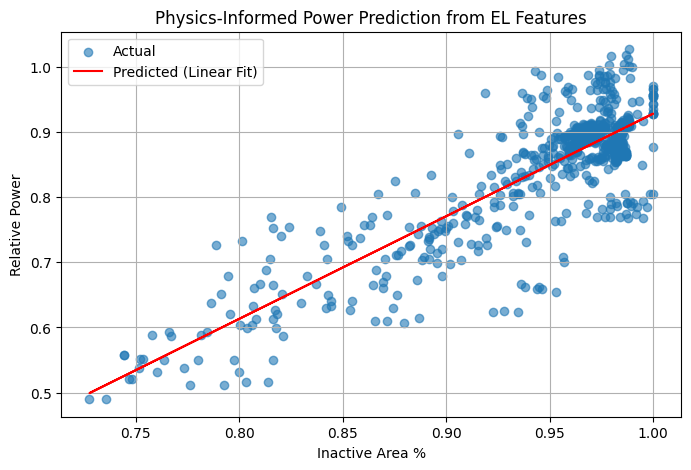

 MAE: 0.0378 | RMSE: 0.0537
 Model weights saved to linreg_weights.csv


In [3]:
# ========================
#  STEP 5: LOAD FEATURES
# ========================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv("/content/el_features.csv")

# ========================
#  STEP 5.5: CLEAN BAD VALUES
# ========================
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["inactive_pct", "nominal_power", "peak_power"])

#  Check data availability
if df.empty:
    raise ValueError(" No valid rows left after cleaning. Check your data for NaNs or Infs.")
else:
    print(f" Proceeding with {len(df)} samples after cleaning.")

# ========================
#  STEP 6: RELATIVE POWER + REGRESSION
# ========================
df["p_rel"] = df["peak_power"] / df["nominal_power"]

X = df[["inactive_pct"]]
X = sm.add_constant(X)
y = df["p_rel"]

model = sm.OLS(y, X).fit()
print(model.summary())

df["p_rel_pred"] = model.predict(X)

# ========================
#  STEP 7: POWER LOSS
# ========================
df["power_loss"] = 1 - df["p_rel_pred"]
df.to_csv("/content/el_power_predictions.csv", index=False)
print(" Results saved to el_power_predictions.csv")

# ========================
#  STEP 8: VISUALIZATION
# ========================
plt.figure(figsize=(8, 5))
plt.scatter(df["inactive_pct"], df["p_rel"], label="Actual", alpha=0.6)
plt.plot(df["inactive_pct"], df["p_rel_pred"], color='red', label="Predicted (Linear Fit)")
plt.xlabel("Inactive Area %")
plt.ylabel("Relative Power")
plt.title("Physics-Informed Power Prediction from EL Features")
plt.legend()
plt.grid(True)
plt.show()

# ========================
#  STEP 9: MAE + RMSE
# ========================
mae = np.mean(np.abs(df["p_rel_pred"] - df["p_rel"]))
rmse = np.sqrt(np.mean((df["p_rel_pred"] - df["p_rel"])**2))
print(f" MAE: {mae:.4f} | RMSE: {rmse:.4f}")

# ========================
#  STEP 10: SAVE MODEL WEIGHTS
# ========================
model.params.to_csv("/content/linreg_weights.csv")
print(" Model weights saved to linreg_weights.csv")

In [ ]:
# ========================
#  INFERENCE WITH ENSEMBLE
# ========================
import torch
from PIL import Image
import numpy as np

def predict_with_ensemble(image_path, model_path='best_ensemble_model.pth'):
    """
    Run inference using the trained ensemble model.
    Returns predictions from physics model, ResNet, and final ensemble.
    """
    try:
        # Setup
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = EnsembleModel()
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        model.eval()
        
        # Preprocess image
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        img = img.resize((224, 224))  # ResNet input size
        img = np.array(img) / 255.0  # Normalize
        img = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0)  # Add batch & channel dims
        img = img.to(device)
        
        # Get predictions
        with torch.no_grad():
            pred_physics, _ = model.physics_model(img)
            pred_resnet, _ = model.resnet_model(img)
            final_pred = model(img)
            
            # Convert to numpy
            pred_physics = pred_physics.cpu().numpy()[0][0]
            pred_resnet = pred_resnet.cpu().numpy()[0][0]
            final_pred = final_pred.cpu().numpy()[0][0]
            
        # Calculate power loss
        power_loss = 1 - final_pred
        
        # Print results
        print("\n📊 Ensemble Inference Results:")
        print(f"   Physics Model: {pred_physics:.4f}")
        print(f"   ResNet Model: {pred_resnet:.4f}")
        print(f"   Ensemble: {final_pred:.4f}")
        print(f"   Power Loss: {power_loss:.4f}")
        
        # Return all predictions
        return {
            "physics": pred_physics,
            "resnet": pred_resnet,
            "ensemble": final_pred,
            "power_loss": power_loss
        }
                
    except Exception as e:
        print(f"❌ Error during inference: {e}")
        return None

# Example usage
if __name__ == "__main__":
    # For Google Colab: Upload and predict
    from google.colab import files
    print("\n📸 Upload an EL image to analyze...")
    uploaded = files.upload()
    
    if uploaded:
        img_path = list(uploaded.keys())[0]
        print(f"Processing: {img_path}")
        results = predict_with_ensemble(img_path)
        
        if results:
            print("\n✅ Analysis completed successfully!")


In [ ]:
# ========================
#  INFERENCE WITH ENSEMBLE
# ========================
import torch
from PIL import Image
import numpy as np

def predict_with_ensemble(image_path, model_path='best_ensemble_model.pth'):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = EnsembleModel()
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        model.eval()
        
        img = Image.open(image_path).convert('L')
        img = img.resize((224, 224))
        img = np.array(img) / 255.0
        img = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0)
        img = img.to(device)
        
        with torch.no_grad():
            pred_physics, _ = model.physics_model(img)
            pred_resnet, _ = model.resnet_model(img)
            final_pred = model(img)
            
            pred_physics = pred_physics.cpu().numpy()[0][0]
            pred_resnet = pred_resnet.cpu().numpy()[0][0]
            final_pred = final_pred.cpu().numpy()[0][0]
            
        power_loss = 1 - final_pred
        
        print(f"\n📊 Ensemble Inference Results:")
        print(f"   Physics Model: {pred_physics:.4f}")
        print(f"   ResNet Model: {pred_resnet:.4f}")
        print(f"   Ensemble: {final_pred:.4f}")
        print(f"   Power Loss: {power_loss:.4f}")
        
        return {"physics": pred_physics, "resnet": pred_resnet, 
                "ensemble": final_pred, "power_loss": power_loss}
                
    except Exception as e:
        print(f"Error: {e}")
        return None

# For testing
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
results = predict_with_ensemble(img_path)


# Inferencing

In [ ]:
# ========================
#  INFERENCE WITH ENSEMBLE
# ========================
import torch
from PIL import Image
import numpy as np

def predict_with_ensemble(image_path, model_path='best_ensemble_model.pth'):
    # Load the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EnsembleModel()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Process image
    img = Image.open(image_path).convert('L')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    img = img.to(device)
    
    # Get predictions
    with torch.no_grad():
        # Get individual model predictions
        pred_physics, _ = model.physics_model(img)
        pred_resnet, _ = model.resnet_model(img)
        
        # Get ensemble prediction
        final_pred = model(img)
        
        # Convert to numpy for printing
        pred_physics = pred_physics.cpu().numpy()[0][0]
        pred_resnet = pred_resnet.cpu().numpy()[0][0]
        final_pred = final_pred.cpu().numpy()[0][0]
        
    # Calculate power loss
    power_loss = 1 - final_pred
    
    print("\n📊 Ensemble Inference Results:")
    print(f"   Physics Model Prediction : {pred_physics:.4f}")
    print(f"   ResNet Model Prediction  : {pred_resnet:.4f}")
    print(f"   Final Ensemble Prediction: {final_pred:.4f}")
    print(f"   Estimated Power Loss     : {power_loss:.4f}")
    
    return final_pred, power_loss

# For Google Colab: Upload and predict
from google.colab import files
uploaded = files.upload()  # Expects one image file

# Get uploaded file path and run prediction
img_path = list(uploaded.keys())[0]
print(f"📸 Uploaded: {img_path}")
pred, loss = predict_with_ensemble(img_path)
            "power_loss": power_loss
        }

    except Exception as e:
        print(f" Error during inference: {e}")
        return None

# ========================
#  RUN INFERENCE
# ========================
_ = predict_power_from_image(img_path)

Saving image_2.png to image_2.png
 Uploaded: image_2.png

 Inference Results:
   Inactive Area % : 0.9854
   Relative Power  : 0.9050
   Power Loss      : 0.0950
